# A Julia é rápida

Frequentemente, programas são executados em diferentes linguagens de programação com o propósito de comparar os desempenhos das linguagens.
Esse tipo de comparação não é simples e pode gerar discussões.

Neste notebook vamos fazer uma comparação simples entre algumas linguagens de programação, e deixar que você tire suas próprias conclusões.

## A função soma

Consideramos a função soma, denotada por `sum`, que é definida por
$$
\mathrm{sum}(a) = \sum_{j=1}^n a_j,
$$
onde $a = [a_1, a_2, \dots, a_j]$ é uma lista com $n$ elementos.

Vamos criar uma lista com 10<sup>7</sup> elementos escolhidos aleatoriamente no intervalo $[0,1]$:

In [1]:
a = rand(10^7)

10000000-element Array{Float64,1}:
 0.16945788316935317
 0.6714803169633543 
 0.811398206891973  
 0.5045447596060275 
 0.82616308840079   
 0.5348142147287673 
 0.46529892858039834
 0.5863192876525101 
 0.3587643495052768 
 0.7942188048480314 
 0.9469707507483438 
 0.15684269858590993
 0.06722852050030781
 ⋮                  
 0.7615571719814589 
 0.7421050746687534 
 0.8490101202965203 
 0.4200744681407007 
 0.8186374657632007 
 0.5591880479887974 
 0.9830719025727932 
 0.7730099796452472 
 0.8204061646897429 
 0.6382546075380038 
 0.43506489271032245
 0.9453575690025138 

Calculamos a soma dos elementos de `a`:

In [2]:
sum(a)

5.001170536992403e6

O resultado esperado é 0.5 * 10<sup>7</sup>, pois o valor médio de cada elemento da lista é igual a 0.5.

## Medindo desempenho de formas diferentes, em linguagens diferentes

In [3]:
@time sum(a)

  0.011083 seconds (5 allocations: 176 bytes)


5.001170536992403e6

In [4]:
@time sum(a)

  0.011295 seconds (5 allocations: 176 bytes)


5.001170536992403e6

In [5]:
@time sum(a)

  0.011397 seconds (5 allocations: 176 bytes)


5.001170536992403e6

Como vemos, a macro `@time` pode fornecer resultados diferentes, portanto não é uma macro muito confiável para comparar desempenhos.

O pacote `BenchmarkTools.jl` fornece um método simples e preciso de fazer comparações.

In [6]:
using Pkg
Pkg.add("BenchmarkTools")

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]


In [7]:
using BenchmarkTools

## 1. C

A linguagem C é considerada uma linguagem difícil para os humanos e simples para as máquinas.

Em uma sessão da Julia, podemos inserir um programa em C, compilá-lo e executá-lo:

In [8]:
using Libdl
C_code = """
#include <stddef.h>
double c_sum(size_t n, double *X) {
    double s = 0.0;
    for (size_t i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""

const Clib = tempname()  # Cria um arquivo temporário

# Compila para uma biblioteca compartilhada passando
# o código C_code para o compilador gcc (só funciona
# se o gcc estiver instalado):

open(`gcc -fPIC -O3 -msse3 -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# Define uma função em Julia que chama a função do C
c_sum(X::Array{Float64}) = ccall(("c_sum", Clib), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum (generic function with 1 method)

In [9]:
c_sum(a)

5.001170536992362e6

In [10]:
c_sum(a) ≈ sum(a)  # Digite \approx e tecle <TAB> para obter o símbolo ≈

true

In [11]:
c_sum(a) - sum(a)

-4.0978193283081055e-8

In [12]:
≈ # é uma abreviação (alias) para a função `isapprox`

isapprox (generic function with 8 methods)

In [13]:
?isapprox

search: isapprox



```
isapprox(x, y; rtol::Real=atol>0 ? 0 : √eps, atol::Real=0, nans::Bool=false, norm::Function)
```

Inexact equality comparison: `true` if `norm(x-y) <= max(atol, rtol*max(norm(x), norm(y)))`. The default `atol` is zero and the default `rtol` depends on the types of `x` and `y`. The keyword argument `nans` determines whether or not NaN values are considered equal (defaults to false).

For real or complex floating-point values, if an `atol > 0` is not specified, `rtol` defaults to the square root of [`eps`](@ref) of the type of `x` or `y`, whichever is bigger (least precise). This corresponds to requiring equality of about half of the significand digits. Otherwise, e.g. for integer arguments or if an `atol > 0` is supplied, `rtol` defaults to zero.

`x` and `y` may also be arrays of numbers, in which case `norm` defaults to the usual `norm` function in LinearAlgebra, but may be changed by passing a `norm::Function` keyword argument. (For numbers, `norm` is the same thing as `abs`.) When `x` and `y` are arrays, if `norm(x-y)` is not finite (i.e. `±Inf` or `NaN`), the comparison falls back to checking whether all elements of `x` and `y` are approximately equal component-wise.

The binary operator `≈` is equivalent to `isapprox` with the default arguments, and `x ≉ y` is equivalent to `!isapprox(x,y)`.

Note that `x ≈ 0` (i.e., comparing to zero with the default tolerances) is equivalent to `x == 0` since the default `atol` is `0`.  In such cases, you should either supply an appropriate `atol` (or use `norm(x) ≤ atol`) or rearrange your code (e.g. use `x ≈ y` rather than `x - y ≈ 0`).   It is not possible to pick a nonzero `atol` automatically because it depends on the overall scaling (the "units") of your problem: for example, in `x - y ≈ 0`, `atol=1e-9` is an absurdly small tolerance if `x` is the [radius of the Earth](https://en.wikipedia.org/wiki/Earth_radius) in meters, but an absurdly large tolerance if `x` is the [radius of a Hydrogen atom](https://en.wikipedia.org/wiki/Bohr_radius) in meters.

# Examples

```jldoctest
julia> 0.1 ≈ (0.1 - 1e-10)
true

julia> isapprox(10, 11; atol = 2)
true

julia> isapprox([10.0^9, 1.0], [10.0^9, 2.0])
true

julia> 1e-10 ≈ 0
false

julia> isapprox(1e-10, 0, atol=1e-8)
true
```


Agora podemos medir o desempenho do código C diretamente da sessão Julia.

In [14]:
c_bench = @benchmark c_sum($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     11.718 ms (0.00% GC)
  median time:      11.748 ms (0.00% GC)
  mean time:        11.748 ms (0.00% GC)
  maximum time:     12.309 ms (0.00% GC)
  --------------
  samples:          426
  evals/sample:     1

In [15]:
println("C: O tempo mais rápido foi $(minimum(c_bench.times) / 1e6) msec")

C: O tempo mais rápido foi 11.71824 msec


In [16]:
d = Dict()
d["C"] = minimum(c_bench.times) / 1e6  # em milisegundos
d

Dict{Any,Any} with 1 entry:
  "C" => 11.7182

In [17]:
using Plots
gr()

Plots.GRBackend()

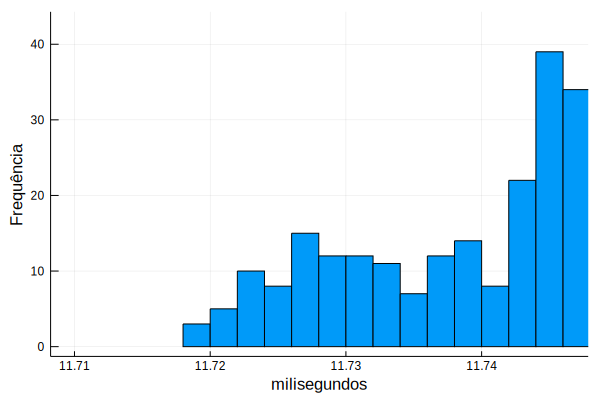

In [18]:
using Statistics
t = c_bench.times / 1e6 # tempos em milisegundos
m, σ = minimum(t), std(t)

histogram(t, bins=500,
    xlim=(m - 0.01, m + σ),
    xlabel="milisegundos", ylabel="Frequência", label="")

## 2. C com -ffast-math

Agora, vamos permitir que o C otimize suas operações de ponto flutuante.
Dessa forma, ele vai vetorizar suas instruções usando [SIMD](https://en.wikipedia.org/wiki/SIMD) (single instruction, multiple data).

In [19]:
const Clib_fastmath = tempname()

# Como acima mas agora com a opção -ffast-math
open(`gcc -fPIC -O3 -msse3 -xc -shared -ffast-math -o $(Clib_fastmath * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# Define uma função em Julia que chama a função em C
c_sum_fastmath(X::Array{Float64}) = ccall(("c_sum", Clib_fastmath), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum_fastmath (generic function with 1 method)

In [20]:
c_fastmath_bench = @benchmark $c_sum_fastmath($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     5.995 ms (0.00% GC)
  median time:      6.073 ms (0.00% GC)
  mean time:        6.958 ms (0.00% GC)
  maximum time:     13.108 ms (0.00% GC)
  --------------
  samples:          718
  evals/sample:     1

In [21]:
d["C com -ffast-math"] = minimum(c_fastmath_bench.times) / 1e6  # em milisegundos

5.995095

## 3. Python

O pacote `PyCall` fornece uma interface entre a Julia e o Python:

In [22]:
Pkg.add("PyCall")

 Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]


In [23]:
using PyCall

In [24]:
# Importa a função "sum" do Python
pysum = pybuiltin("sum")

PyObject <built-in function sum>

In [25]:
pysum(a)

5.001170536992362e6

In [26]:
pysum(a) ≈ sum(a)

true

In [27]:
py_list_bench = @benchmark $pysum($a)

BenchmarkTools.Trial: 
  memory estimate:  368 bytes
  allocs estimate:  8
  --------------
  minimum time:     1.345 s (0.00% GC)
  median time:      1.385 s (0.00% GC)
  mean time:        1.394 s (0.00% GC)
  maximum time:     1.463 s (0.00% GC)
  --------------
  samples:          4
  evals/sample:     1

In [28]:
d["Python"] = minimum(py_list_bench.times) / 1e6
d

Dict{Any,Any} with 3 entries:
  "C com -ffast-math" => 5.9951
  "C"                 => 11.7182
  "Python"            => 1344.9

## 4. Python `numpy`

A biblioteca `numpy` do Python é escrita em C e também utiliza SIMD.
Essa biblioteca pode ser instalada na Julia da seguinte forma:

In [29]:
Pkg.add("Conda")

 Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]


In [30]:
using Conda

In [31]:
numpy_sum = pyimport("numpy")["sum"]

py_numpy_bench = @benchmark $numpy_sum($a)

┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = top-level scope at In[31]:1
└ @ Core In[31]:1


BenchmarkTools.Trial: 
  memory estimate:  368 bytes
  allocs estimate:  8
  --------------
  minimum time:     5.339 ms (0.00% GC)
  median time:      5.618 ms (0.00% GC)
  mean time:        5.585 ms (0.00% GC)
  maximum time:     10.205 ms (0.00% GC)
  --------------
  samples:          895
  evals/sample:     1

In [32]:
numpy_sum(a)

5.001170536992405e6

In [33]:
numpy_sum(a) ≈ sum(a)

true

In [34]:
d["Python numpy"] = minimum(py_numpy_bench.times) / 1e6
d

Dict{Any,Any} with 4 entries:
  "C com -ffast-math" => 5.9951
  "C"                 => 11.7182
  "Python numpy"      => 5.33924
  "Python"            => 1344.9

## 5. Python (escrito à mão)

In [35]:
py"""
def py_sum(A):
    s = 0.0
    for a in A:
        s += a
    return s
"""

sum_py = py"py_sum"

PyObject <function py_sum at 0x7f89ea253f80>

In [36]:
py_hand = @benchmark $sum_py($a)

BenchmarkTools.Trial: 
  memory estimate:  368 bytes
  allocs estimate:  8
  --------------
  minimum time:     1.687 s (0.00% GC)
  median time:      1.690 s (0.00% GC)
  mean time:        1.696 s (0.00% GC)
  maximum time:     1.711 s (0.00% GC)
  --------------
  samples:          3
  evals/sample:     1

In [37]:
sum_py(a)

5.001170536992362e6

In [38]:
sum_py(a) ≈ sum(a)

true

In [39]:
d["Python escrito à mão"] = minimum(py_hand.times) / 1e6
d

Dict{Any,Any} with 5 entries:
  "C com -ffast-math"    => 5.9951
  "Python escrito à mão" => 1687.4
  "C"                    => 11.7182
  "Python numpy"         => 5.33924
  "Python"               => 1344.9

## 6. Julia

Em Julia, a função `sum` é escrita em Julia, não em C.

In [40]:
@which sum(a)

sum(a::AbstractArray) in Base at reducedim.jl:652

In [41]:
j_bench = @benchmark sum($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     5.544 ms (0.00% GC)
  median time:      5.592 ms (0.00% GC)
  mean time:        5.601 ms (0.00% GC)
  maximum time:     6.613 ms (0.00% GC)
  --------------
  samples:          892
  evals/sample:     1

In [42]:
d["Julia"] = minimum(j_bench.times) / 1e6
d

Dict{Any,Any} with 6 entries:
  "C com -ffast-math"    => 5.9951
  "Python escrito à mão" => 1687.4
  "C"                    => 11.7182
  "Python numpy"         => 5.33924
  "Julia"                => 5.54414
  "Python"               => 1344.9

## 7. Julia (escrito à mão)

In [43]:
function mysum(A)   
    s = 0.0 # s = zero(eltype(a))
    for a in A
        s += a
    end
    s
end

mysum (generic function with 1 method)

In [44]:
j_bench_hand = @benchmark mysum($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     11.725 ms (0.00% GC)
  median time:      11.748 ms (0.00% GC)
  mean time:        11.747 ms (0.00% GC)
  maximum time:     12.791 ms (0.00% GC)
  --------------
  samples:          426
  evals/sample:     1

In [45]:
d["Julia escrito à mão"] = minimum(j_bench_hand.times) / 1e6
d

Dict{Any,Any} with 7 entries:
  "C com -ffast-math"    => 5.9951
  "Python escrito à mão" => 1687.4
  "C"                    => 11.7182
  "Python numpy"         => 5.33924
  "Julia escrito à mão"  => 11.7252
  "Julia"                => 5.54414
  "Python"               => 1344.9

## 8. Julia (escrito à mão com SIMD)

In [46]:
function mysum_simd(A)   
    s = 0.0 # s = zero(eltype(A))
    @simd for a in A
        s += a
    end
    s
end

mysum_simd (generic function with 1 method)

In [47]:
j_bench_hand_simd = @benchmark mysum_simd($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     5.512 ms (0.00% GC)
  median time:      5.561 ms (0.00% GC)
  mean time:        5.568 ms (0.00% GC)
  maximum time:     6.583 ms (0.00% GC)
  --------------
  samples:          897
  evals/sample:     1

In [48]:
mysum_simd(a)

5.001170536992385e6

In [49]:
d["Julia escrito à mão com SIMD"] = minimum(j_bench_hand_simd.times) / 1e6
d

Dict{Any,Any} with 8 entries:
  "Julia escrito à mão com SIMD" => 5.51176
  "C com -ffast-math"            => 5.9951
  "Python escrito à mão"         => 1687.4
  "C"                            => 11.7182
  "Python numpy"                 => 5.33924
  "Julia escrito à mão"          => 11.7252
  "Julia"                        => 5.54414
  "Python"                       => 1344.9

## Em resumo

In [50]:
for (key, value) in sort(collect(d), by=last)
    println(rpad(key, 30, "."), lpad(round(value; digits=1), 6, "."))
end

Python numpy.....................5.3
Julia escrito à mão com SIMD.....5.5
Julia............................5.5
C com -ffast-math................6.0
C...............................11.7
Julia escrito à mão.............11.7
Python........................1344.9
Python escrito à mão..........1687.4
